In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/yermaand/audio-nn'

In [3]:
from glob import glob
import os
import shutil
import subprocess
from src import *
import matplotlib.pyplot as plt
import scipy.signal as S

No module named 'gurobipy'


In [6]:
def plot_alignment(signals, ax=plt, sr=44100, each=100, from_time=0, till_time=60*3):
    from_sample = int(sr * from_time)
    till_sample = int(sr * till_time)
    if ax == plt:
        ax.figure(figsize=(20, 10))
    for signal in signals:
        ax.plot(signal[from_sample:till_sample:each], alpha=0.5)

def align_signals(reference, target, sr=44100):
    corr = S.correlate(reference, target)
    lags = S.correlation_lags(len(reference), len(target))
    lag = lags[corr.argmax()]
    print(f'lag: {lag / sr:.2f} [s]')
    
    if lag > 0:
        return torch.cat([torch.zeros(lag), target[:-lag]])
    else:
        lag = abs(lag)
        # return torch.cat([target[lag:], torch.zeros(lag)])
        return target[lag:]

# Part I

In [7]:
files = load_files_from_dataset('010_RX100_eyedea_august')
files_all = load_files_from_dataset('009_eyedea_august')

In [8]:
alignmnemt_dict = {k: [] for k in files}

for k, v in alignmnemt_dict.items():
    for file_path in files_all:
        file_name = file_path.split('/')[-1].split('.')[0]
        if file_name[:2] == k[:2] and file_name != k and file_name not in alignmnemt_dict[k]:
            alignmnemt_dict[k].append(file_name)
print(alignmnemt_dict)

{
    '42_RadotinskaJ2_RX100': ['42_RadotinskaJ2_Mobius'],
    '43_PrazskaDobrichovice_RX100': ['43_PrazskaDobrichovice_Mobius'],
    '44_Cementarska_RX100': ['44_Cementarska_Mobius'],
    '45_RX100': ['45_Mobius', '45_iphonexs'],
    '46_RX100': ['46_Mobius', '46_iphonexs'],
    '47_RX100': ['47_Mobius'],
    '48_RX100': ['48_Mobius', '48_iphonexs'],
    '49_RX100': ['49_Mobius', '49_iphonexs'],
    '50_RX100': ['50_Mobius', '50_Samsung'],
    '51_RX100': ['51_Mobius', '51_Samsung'],
    '52_RX100': ['52_Mobius', '52_Samsung'],
    '53_RX100': ['53_Mobius', '53_Samsung'],
    '54_RX100': ['54_Mobius', '54_Samsung'],
    '55_RX100': ['55_Samsung'],
    '56_RX100': ['56_Mobius', '56_Samsung'],
    '58_RX100': ['58_Mobius', '58_Samsung'],
    '59_RX100': ['59_Samsung'],
    '60_RX100': ['60_Samsung'],
    '61_RX100': ['61_Mobius', '61_Samsung']
}

### Example

lag -1.28

lag -2.17

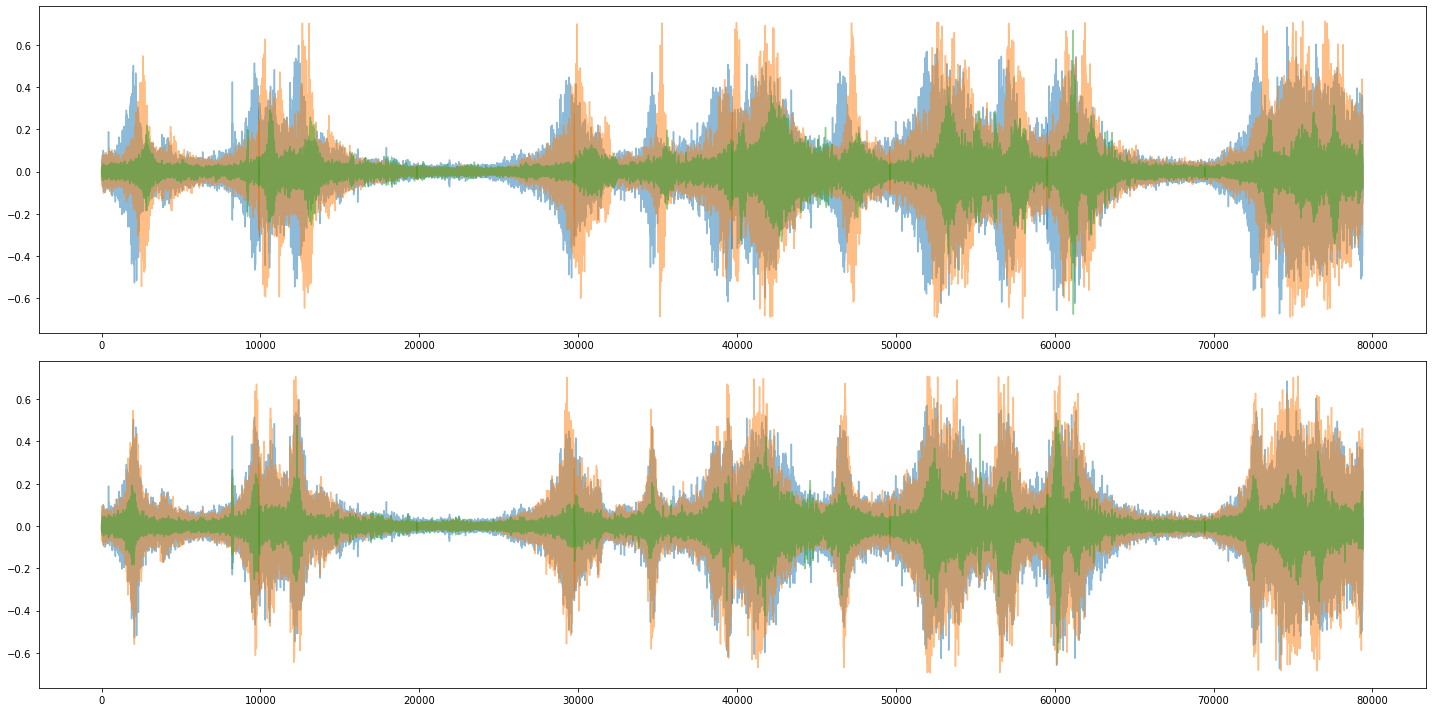

In [8]:
# example
# load wav files
signal_1, sr = load_audio('32_Cementarska_RX100', return_sr=True)
signal_2 = load_audio('32_Cementarska_Mobius')
signal_3 = load_audio('32_Cementarska_iphone')

# align 
signal_2_aligned = align_signals(signal_1, signal_2)
signal_3_aligned = align_signals(signal_1, signal_3)

# show
fig, axes = plt.subplots(2, figsize=(20, 10))
plot_alignment([signal_1, signal_2, signal_3], ax=axes[0])
plot_alignment([signal_1, signal_2_aligned, signal_3_aligned], ax=axes[1])
plt.tight_layout() 

# save
# torch.save([signal_1, sr], 'data/audio_tensors/12_RX100.MP4.pt')
# torch.save([signal_2_aligned, sr], 'data/audio_tensors/12_iphone.MP4.pt')
# torch.save([signal_3_aligned, sr], 'data/audio_tensors/12_Mobius.MP4.pt')

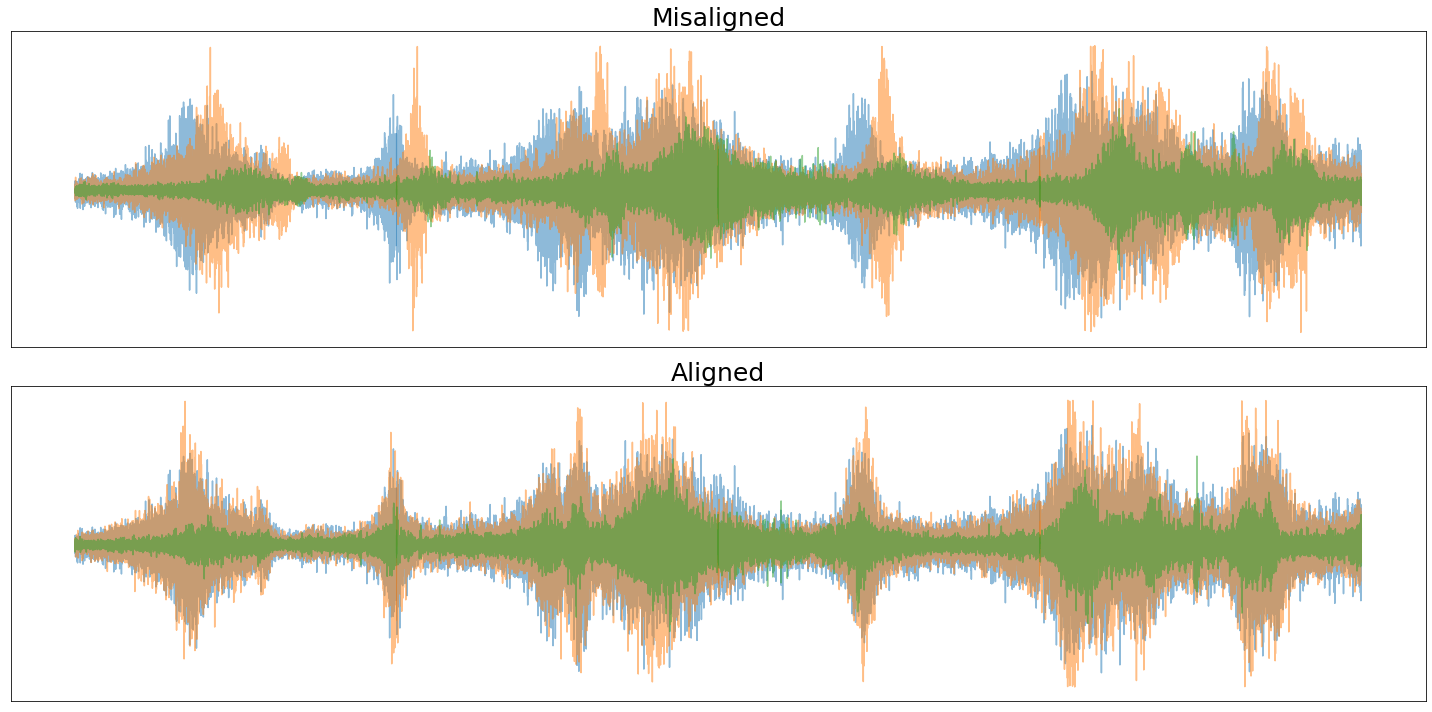

In [12]:
fig, axes = plt.subplots(2, figsize=(20, 10))

from_time = 60
till_time = 60 * 2 + 15
plot_alignment([signal_1, signal_2, signal_3], from_time=from_time, till_time=till_time, ax=axes[0])
plot_alignment([signal_1, signal_2_aligned, signal_3_aligned], from_time=from_time, till_time=till_time, ax=axes[1])
for ax in axes:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
axes[0].set_title('Misaligned', fontsize=25)
axes[1].set_title('Aligned', fontsize=25)
plt.tight_layout()
plt.savefig('plots/aligned_signals.png', dpi=150)

In [11]:
get_signal_length(signal_1, sr), get_signal_length(signal_2, sr), get_signal_length(signal_3, sr)

(1236, 1232, 1235)

### Cycle

In [10]:
subfolder = 'eyedea_aligned'
reference_camera_name = 'RX100'

reference: 42_RadotinskaJ2_RX100

target: 42_RadotinskaJ2_Mobius

lag -0.23

aligned signal length: 1324

reference: 43_PrazskaDobrichovice_RX100

target: 43_PrazskaDobrichovice_Mobius

lag -2.44

aligned signal length: 1380

reference: 44_Cementarska_RX100

target: 44_Cementarska_Mobius

lag 6.04

aligned signal length: 1296

reference: 45_RX100

target: 45_Mobius

lag 2.37

aligned signal length: 1297

target: 45_iphonexs

lag 2.32

aligned signal length: 1296

reference: 46_RX100

target: 46_Mobius

lag -0.22

aligned signal length: 1339

target: 46_iphonexs

lag -3.90

aligned signal length: 1338

reference: 47_RX100

target: 47_Mobius

lag -2.12

aligned signal length: 1327

reference: 48_RX100

target: 48_Mobius

lag 0.85

aligned signal length: 1300

target: 48_iphonexs

lag -0.65

aligned signal length: 1301

reference: 49_RX100

target: 49_Mobius

lag 1.18

aligned signal length: 1199

target: 49_iphonexs

lag -0.84

aligned signal length: 1198

reference: 50_RX100

target: 50_Mobius

lag -1.18

aligned signal length: 1224

target: 50_Samsung

lag 0.77

aligned signal length: 1225

reference: 51_RX100

target: 51_Mobius

lag 2.19

aligned signal length: 1234

target: 51_Samsung

lag -2.28

aligned signal length: 1236

reference: 52_RX100

target: 52_Mobius

lag -0.53

aligned signal length: 1248

target: 52_Samsung

lag 2.85

aligned signal length: 1243

reference: 53_RX100

target: 53_Mobius

lag -0.11

aligned signal length: 1205

target: 53_Samsung

lag 1.45

aligned signal length: 1206

reference: 54_RX100

target: 54_Mobius

lag 2.38

aligned signal length: 1220

target: 54_Samsung

lag 1.07

aligned signal length: 1222

reference: 55_RX100

target: 55_Samsung

lag 0.48

aligned signal length: 1150

reference: 56_RX100

target: 56_Mobius

lag -0.08

aligned signal length: 1225

target: 56_Samsung

lag -4.15

aligned signal length: 1226

reference: 58_RX100

target: 58_Mobius

lag -1.42

aligned signal length: 1218

target: 58_Samsung

lag -2.23

aligned signal length: 1221

reference: 59_RX100

target: 59_Samsung

lag 0.38

aligned signal length: 1245

reference: 60_RX100

target: 60_Samsung

lag 1.56

aligned signal length: 1404

reference: 61_RX100

target: 61_Mobius

lag -3.29

aligned signal length: 1209

target: 61_Samsung

lag -1.62

aligned signal length: 1207

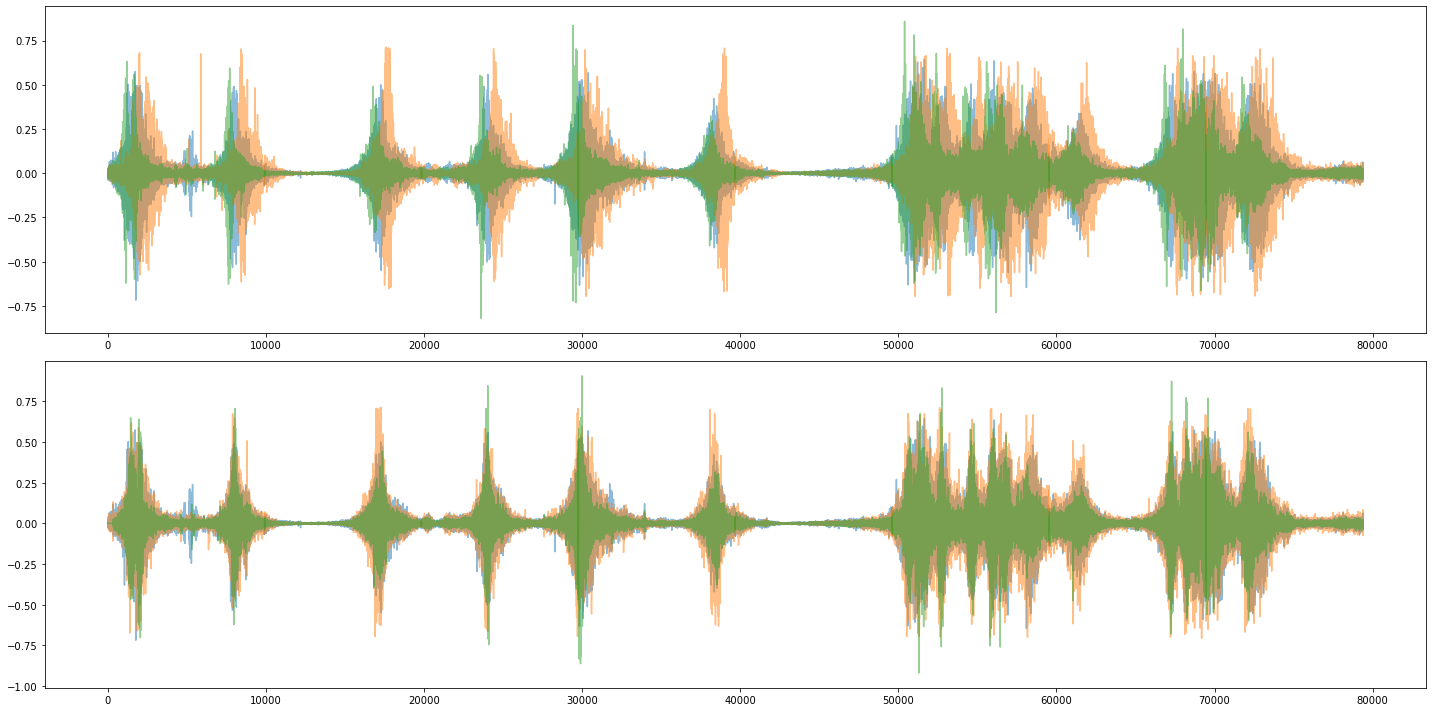

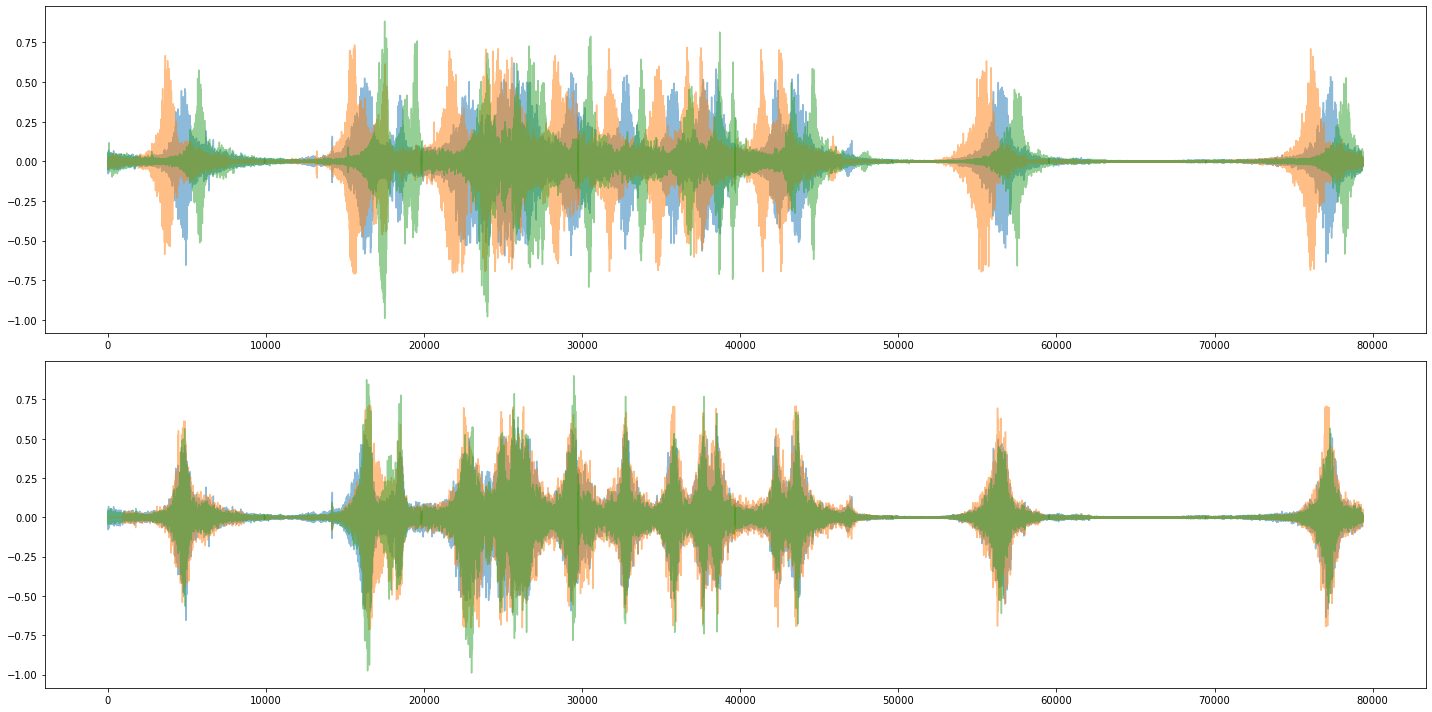

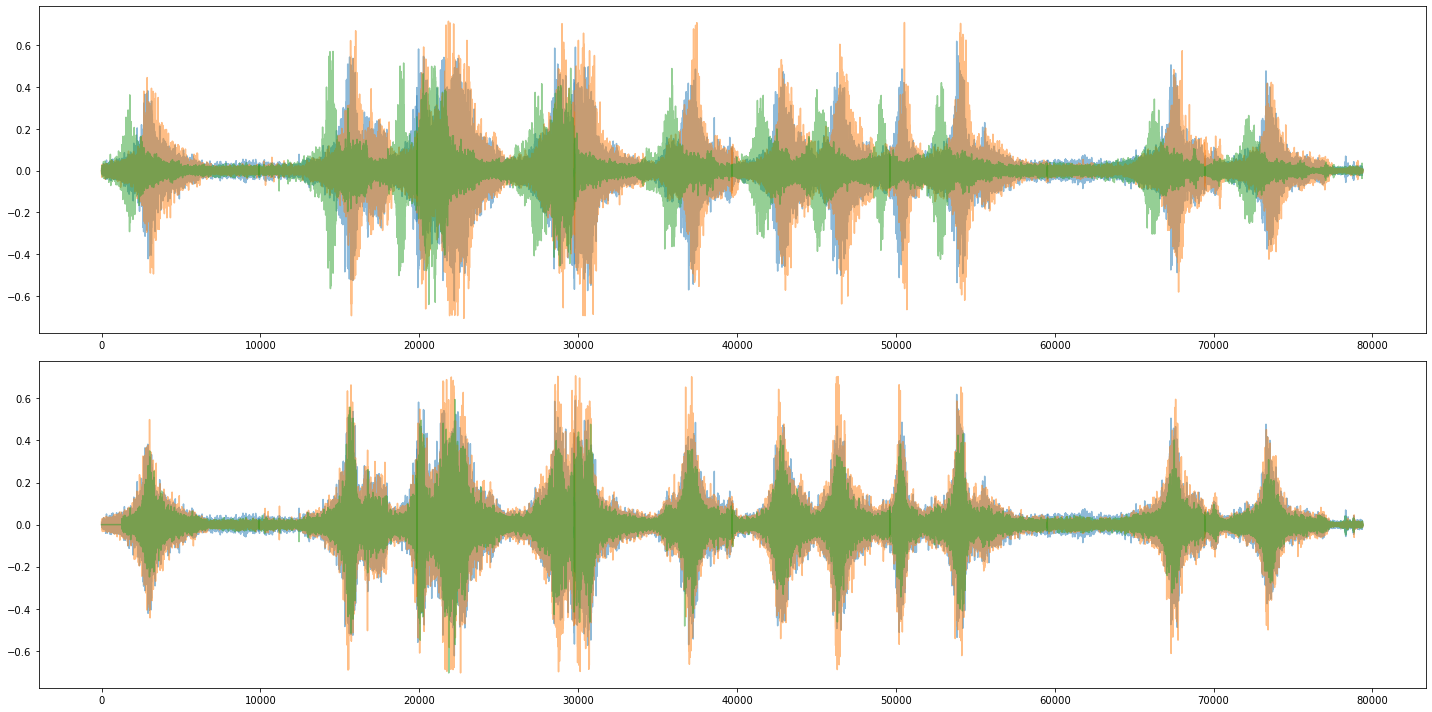

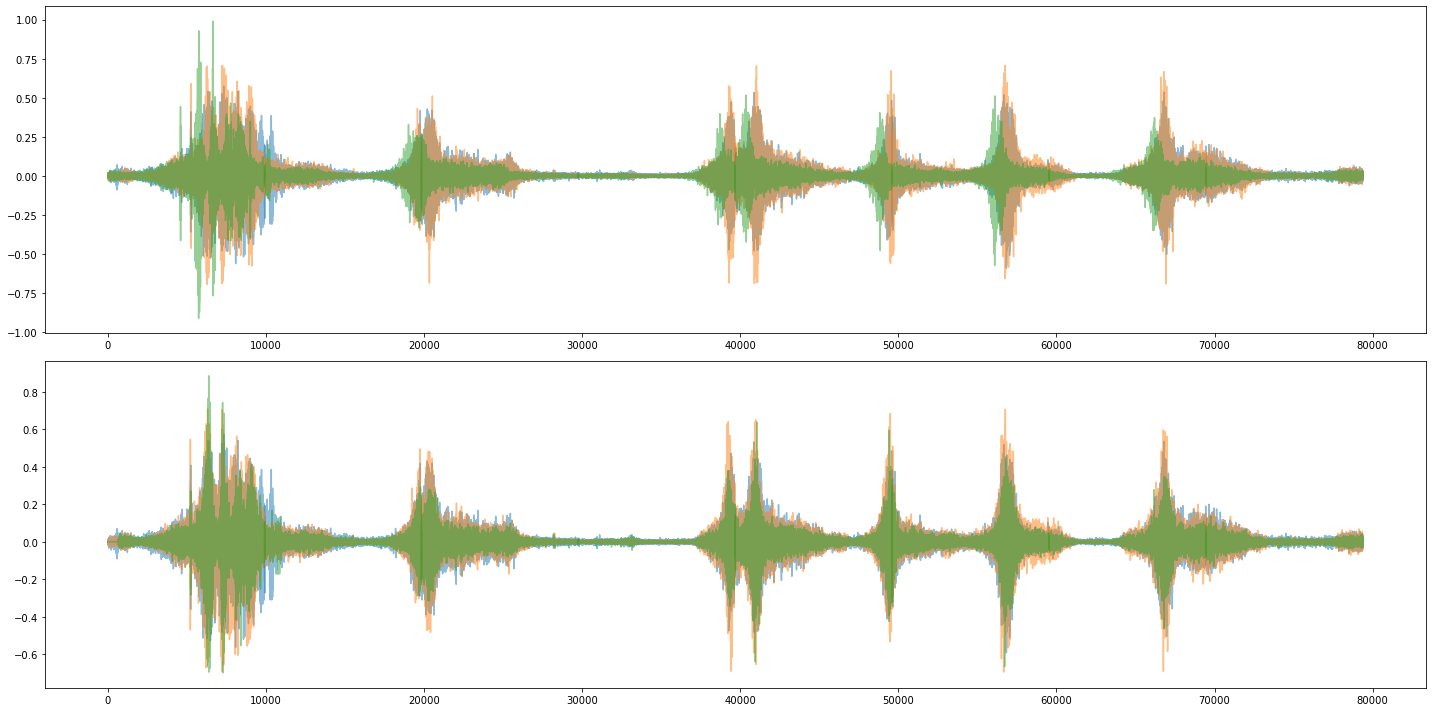

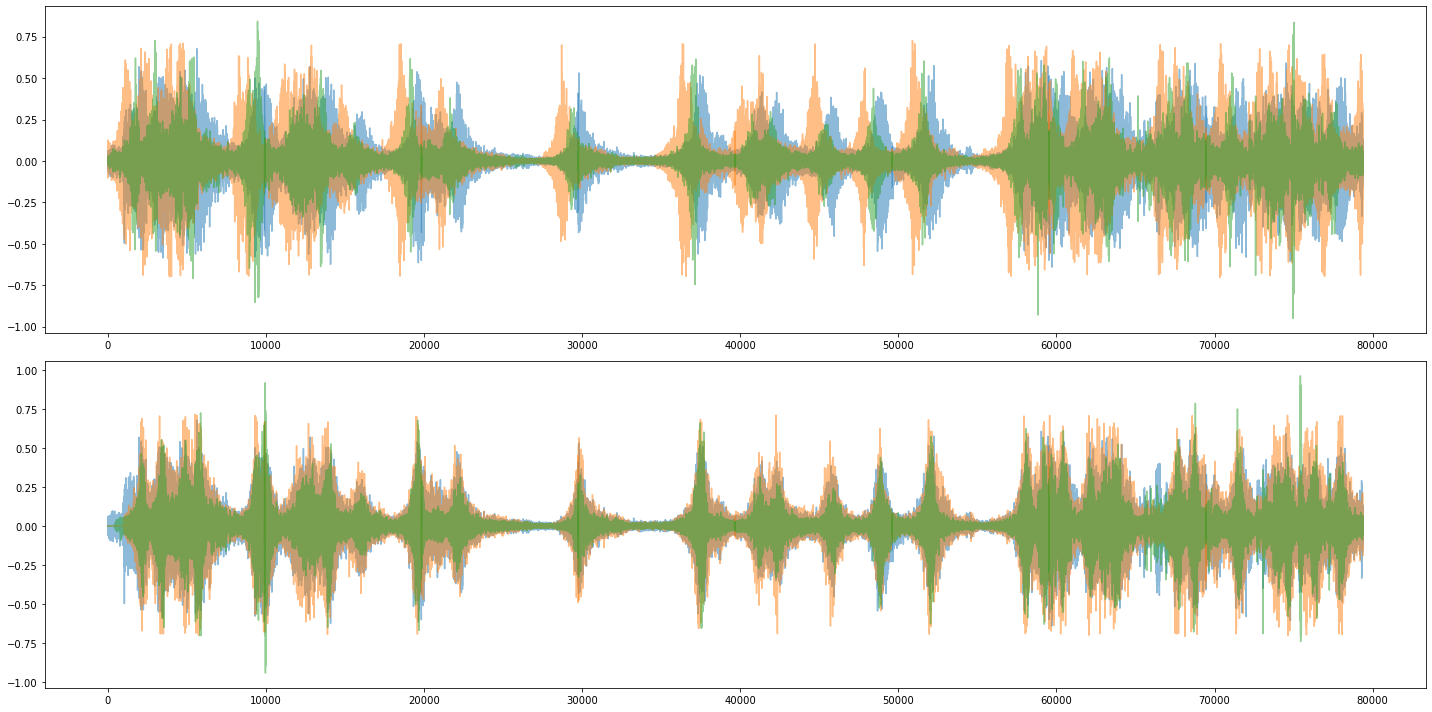

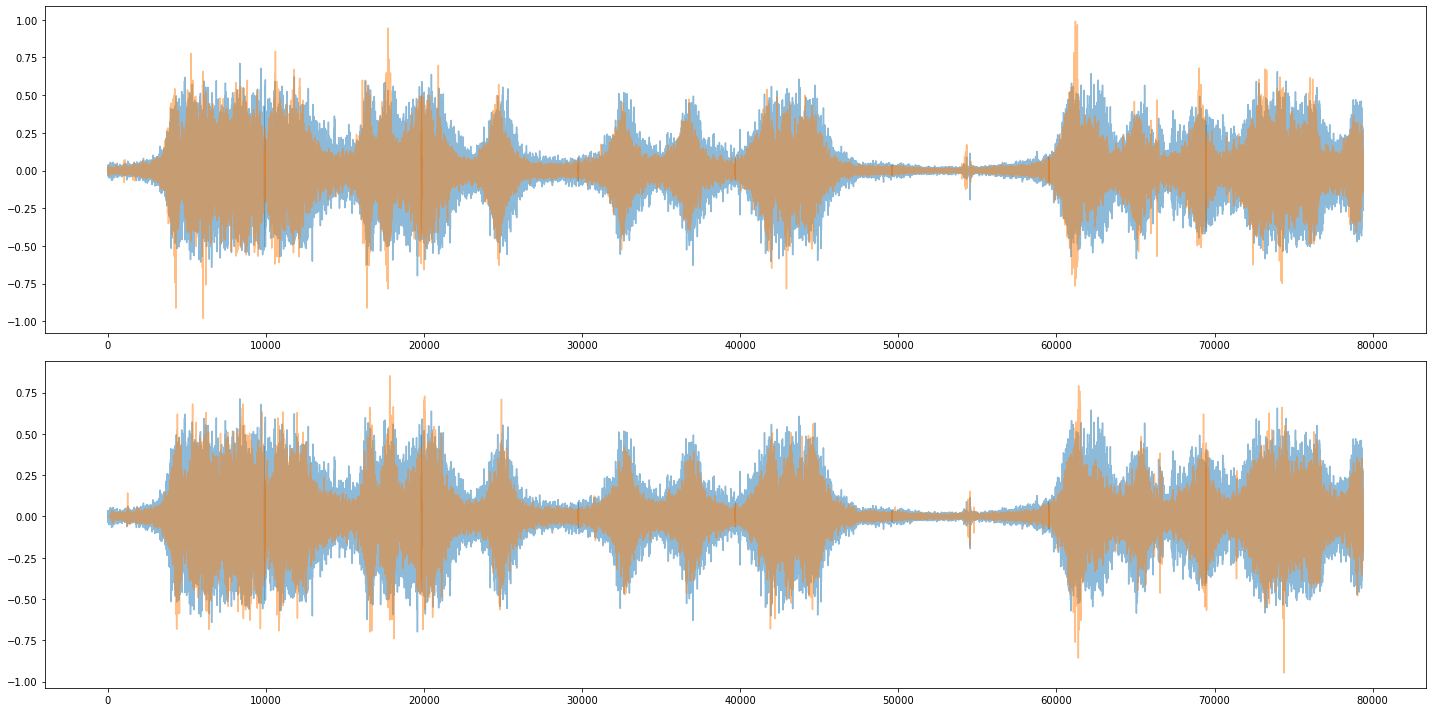

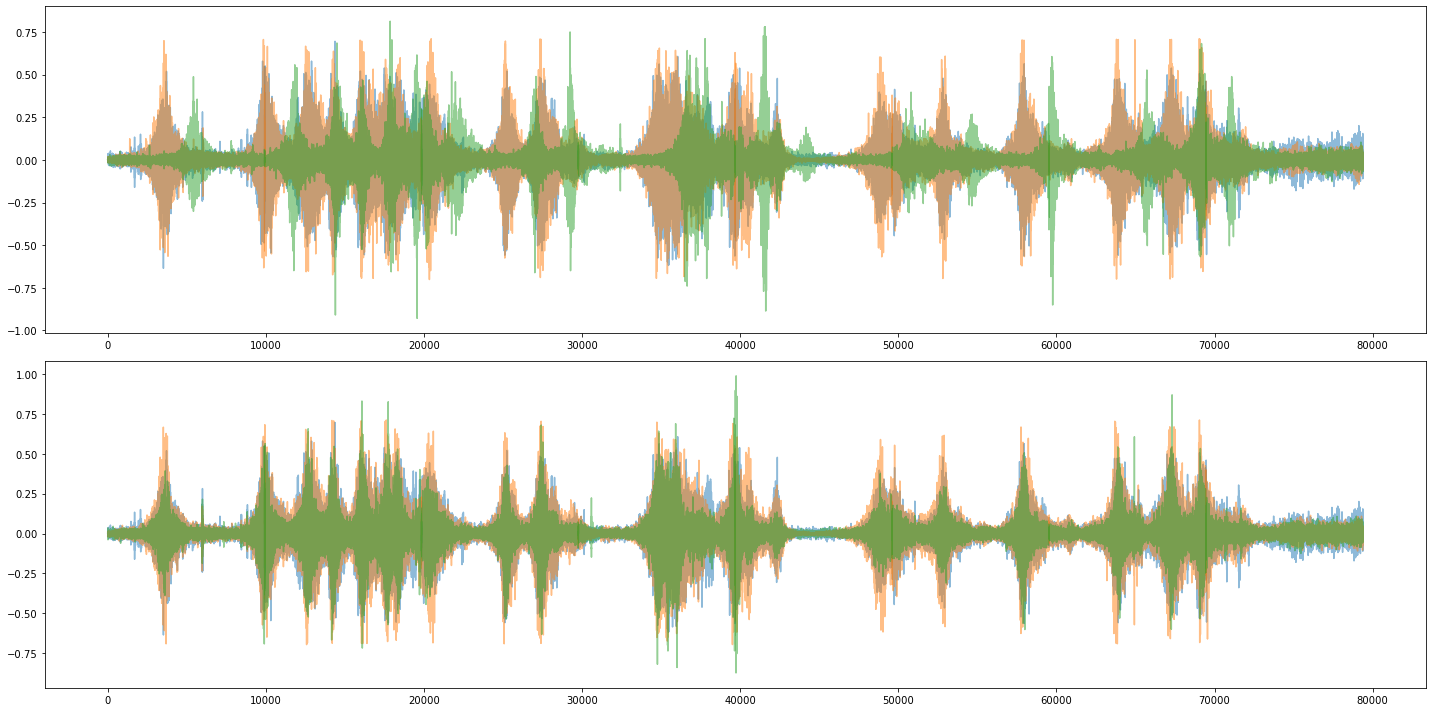

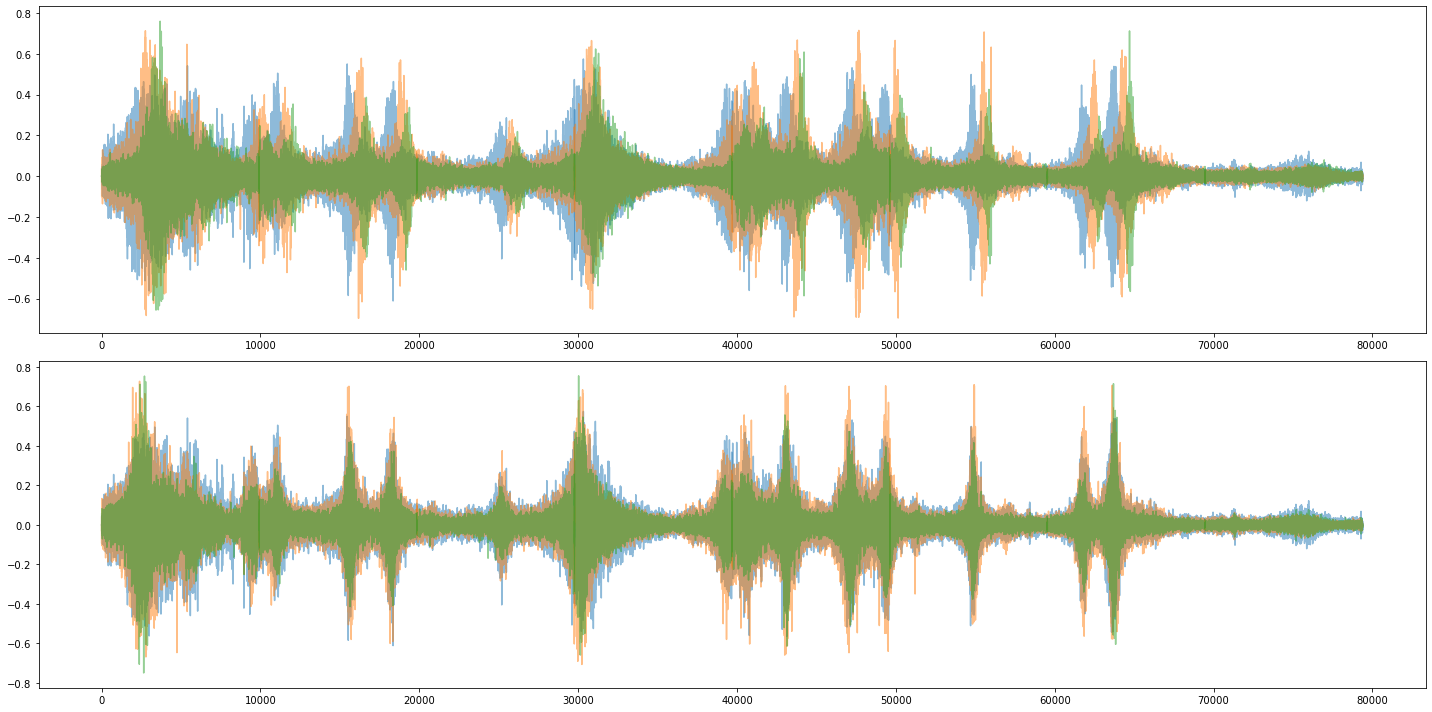

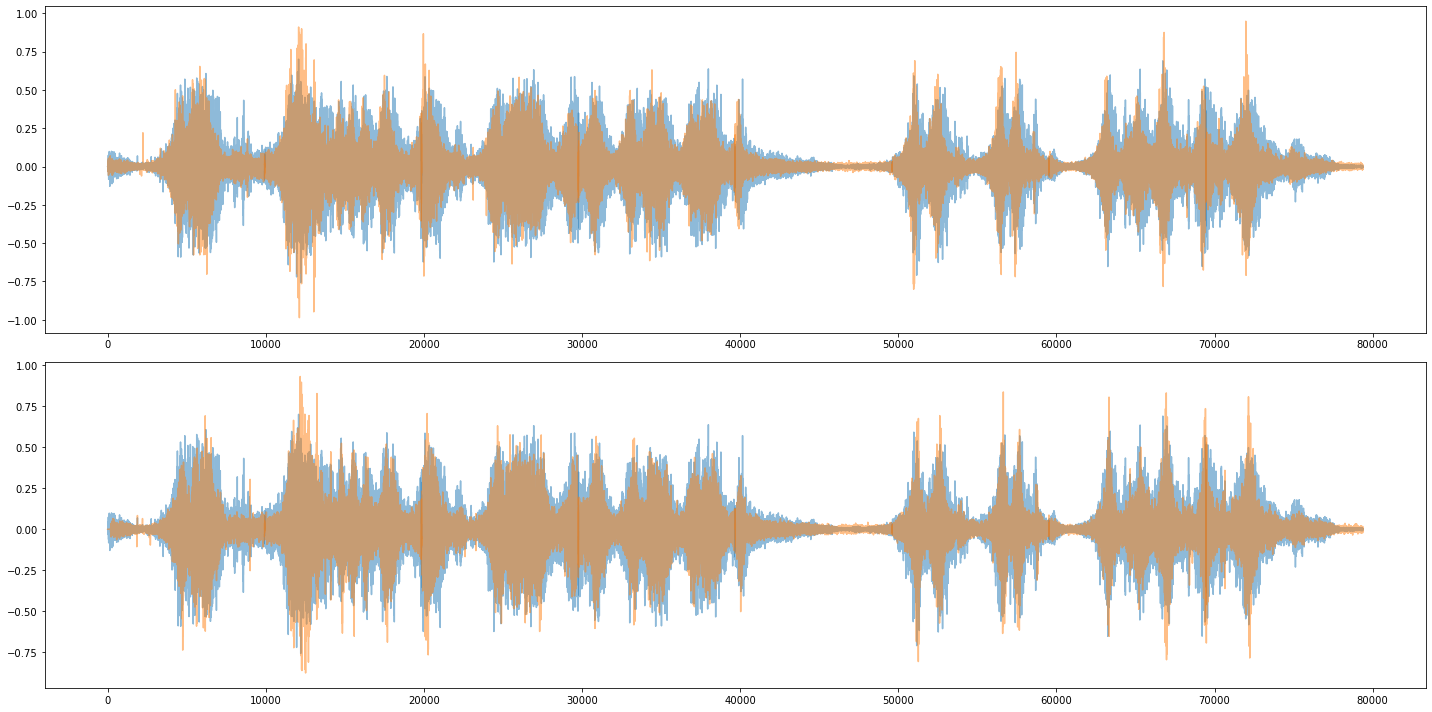

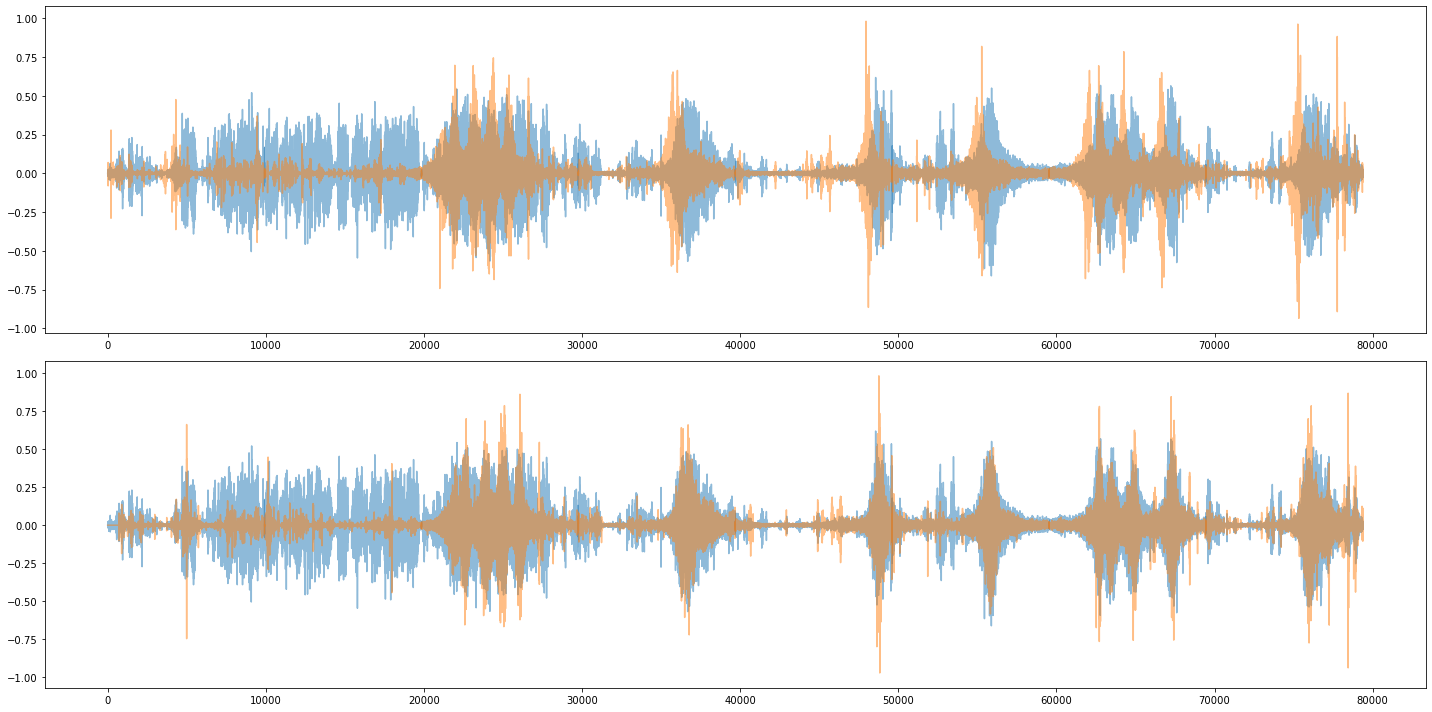

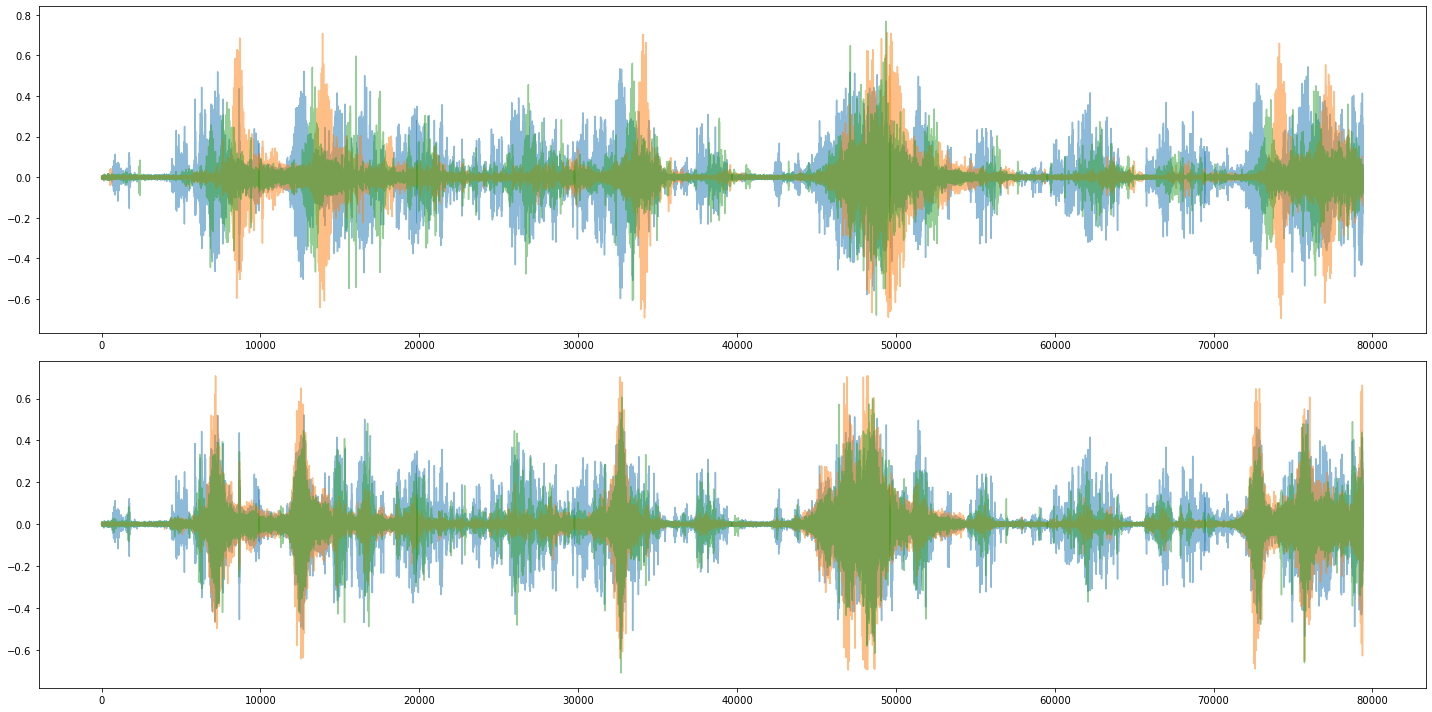

In [10]:
os.makedirs(f'data/audio_pt/{subfolder}', exist_ok=True)
os.makedirs(f'data/csv/{subfolder}', exist_ok=True)

for reference_name, targets in alignmnemt_dict.items():
    print(f'\nreference: {reference_name}')

    # load reference signal
    reference_signal, sr = load_audio(reference_name, return_sr=True)
    
    signals = [reference_signal]
    signals_aligned = [reference_signal]
    for target_name in targets:
        print(f'target: {target_name}')
        
        # load target signal
        target_signal = load_audio_wav(f'data/audio_wav/{target_name}.wav')
        signals.append(target_signal)

        # align reference and target signals
        aligned_signal = align_signals(reference_signal, target_signal)
        signals_aligned.append(aligned_signal)

        print(f'aligned signal length: {get_signal_length(aligned_signal, sr)} [s]')

        # save aligned target signal
        audio_pt = f'data/audio_pt/{subfolder}/{target_name}_aligned_{reference_camera_name}.pt'
        if not os.path.exists(audio_pt):
            torch.save([aligned_signal, sr], audio_pt)
        
        # save csv
        csv_reference = find_csv(reference_name)
        csv_target = f'data/csv/{subfolder}/{target_name}_aligned_{reference_camera_name}.csv'
        if not os.path.exists(csv_target):
            shutil.copy2(csv_reference, csv_target)

    plt_path = f'plots/alignments/{reference_name}.png'
    fig, axes = plt.subplots(2, figsize=(20, 10))
    plot_alignment(signals, ax=axes[0])
    plot_alignment(signals_aligned, ax=axes[1])
    plt.tight_layout()
    plt.savefig(plt_path)


In [11]:
files_to_preprocess = []
for f in load_dataset('009_eyedea_august'):
    if reference_camera_name not in f[0]:
        f[0] += f'_aligned_{reference_camera_name}'
        files_to_preprocess.append(f)

files_to_preprocess

[['42_RadotinskaJ2_Mobius_aligned_RX100', 0],
 ['43_PrazskaDobrichovice_Mobius_aligned_RX100', 0],
 ['44_Cementarska_Mobius_aligned_RX100', 0],
 ['45_Mobius_aligned_RX100', 1],
 ['45_iphonexs_aligned_RX100', 1],
 ['46_Mobius_aligned_RX100', 1],
 ['46_iphonexs_aligned_RX100', 1],
 ['47_Mobius_aligned_RX100', 1],
 ['48_Mobius_aligned_RX100', 1],
 ['48_iphonexs_aligned_RX100', 1],
 ['49_Mobius_aligned_RX100', 1],
 ['49_iphonexs_aligned_RX100', 1],
 ['50_Mobius_aligned_RX100', 1],
 ['50_Samsung_aligned_RX100', 1],
 ['51_Mobius_aligned_RX100', 1],
 ['51_Samsung_aligned_RX100', 1],
 ['52_Mobius_aligned_RX100', 1],
 ['52_Samsung_aligned_RX100', 1],
 ['53_Mobius_aligned_RX100', 1],
 ['53_Samsung_aligned_RX100', 1],
 ['54_Mobius_aligned_RX100', 1],
 ['54_Samsung_aligned_RX100', 1],
 ['55_Samsung_aligned_RX100', 1],
 ['56_Mobius_aligned_RX100', 1],
 ['56_Samsung_aligned_RX100', 1],
 ['58_Mobius_aligned_RX100', 1],
 ['58_Samsung_aligned_RX100', 1],
 ['59_Samsung_aligned_RX100', 1],
 ['60_Samsung_

In [26]:
aligned_yaml_dataset = []
for f in load_dataset('009_eyedea_august'):
    # f[0] = '- '+ f[0]
    if reference_camera_name not in f[0]:
        f[0] += f'_aligned_{reference_camera_name}'
        aligned_yaml_dataset.append(f)
    else:
        aligned_yaml_dataset.append(f)

aligned_yaml_dataset

import yaml

with open('config/dataset/010_eyedea_august_aligned_RX100.yaml', 'w') as yaml_file:
    yaml.dump(aligned_yaml_dataset, yaml_file, default_flow_style=None)

In [12]:
from preprocess_data import preprocess

preprocess(files_to_preprocess)

--------------------------------------------------

File:  42_RadotinskaJ2_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/42_RadotinskaJ2_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/42_RadotinskaJ2_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/42_RadotinskaJ2_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  43_PrazskaDobrichovice_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/43_PrazskaDobrichovice_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/43_PrazskaDobrichovice_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/43_PrazskaDobrichovice_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  44_Cementarska_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/44_Cementarska_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/44_Cementarska_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/44_Cementarska_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  45_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/45_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/45_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/45_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  45_iphonexs_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/45_iphonexs_aligned_RX100.pt exists

Extracting labels

file data/labels/45_iphonexs_aligned_RX100.txt exists

Extracting intervals

file data/intervals/45_iphonexs_aligned_RX100.txt exists

--------------------------------------------------

File:  46_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/46_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/46_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/46_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  46_iphonexs_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/46_iphonexs_aligned_RX100.pt exists

Extracting labels

file data/labels/46_iphonexs_aligned_RX100.txt exists

Extracting intervals

file data/intervals/46_iphonexs_aligned_RX100.txt exists

--------------------------------------------------

File:  47_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/47_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/47_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/47_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  48_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/48_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/48_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/48_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  48_iphonexs_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/48_iphonexs_aligned_RX100.pt exists

Extracting labels

file data/labels/48_iphonexs_aligned_RX100.txt exists

Extracting intervals

file data/intervals/48_iphonexs_aligned_RX100.txt exists

--------------------------------------------------

File:  49_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/49_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/49_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/49_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  49_iphonexs_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/49_iphonexs_aligned_RX100.pt exists

Extracting labels

file data/labels/49_iphonexs_aligned_RX100.txt exists

Extracting intervals

file data/intervals/49_iphonexs_aligned_RX100.txt exists

--------------------------------------------------

File:  50_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/50_Mobius_aligned_RX100.pt exists

Extracting labels

file data/labels/50_Mobius_aligned_RX100.txt exists

Extracting intervals

file data/intervals/50_Mobius_aligned_RX100.txt exists

--------------------------------------------------

File:  50_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/50_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1225

50_Samsung_aligned_RX100: 1.35, 0.75

Extracting intervals

data/intervals/50_Samsung_aligned_RX100.txt 29

--------------------------------------------------

File:  51_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/51_Mobius_aligned_RX100.pt exists

Extracting labels

signal_length: 1234

51_Mobius_aligned_RX100: 1.55, 0.65

Extracting intervals

data/intervals/51_Mobius_aligned_RX100.txt 23

--------------------------------------------------

File:  51_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/51_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1236

51_Samsung_aligned_RX100: 1.25, 0.75

Extracting intervals

data/intervals/51_Samsung_aligned_RX100.txt 23

--------------------------------------------------

File:  52_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/52_Mobius_aligned_RX100.pt exists

Extracting labels

signal_length: 1248

52_Mobius_aligned_RX100: 1.45, 0.75

Extracting intervals

data/intervals/52_Mobius_aligned_RX100.txt 30

--------------------------------------------------

File:  52_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/52_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1243

52_Samsung_aligned_RX100: 1.45, 0.85

Extracting intervals

data/intervals/52_Samsung_aligned_RX100.txt 30

--------------------------------------------------

File:  53_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/53_Mobius_aligned_RX100.pt exists

Extracting labels

signal_length: 1205

53_Mobius_aligned_RX100: 1.45, 0.75

Extracting intervals

data/intervals/53_Mobius_aligned_RX100.txt 28

--------------------------------------------------

File:  53_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/53_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1206

53_Samsung_aligned_RX100: 1.35, 0.85

Extracting intervals

data/intervals/53_Samsung_aligned_RX100.txt 28

--------------------------------------------------

File:  54_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/54_Mobius_aligned_RX100.pt exists

Extracting labels

signal_length: 1220

54_Mobius_aligned_RX100: 1.75, 0.65

Extracting intervals

data/intervals/54_Mobius_aligned_RX100.txt 17

--------------------------------------------------

File:  54_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/54_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1222

54_Samsung_aligned_RX100: 1.55, 0.75

Extracting intervals

data/intervals/54_Samsung_aligned_RX100.txt 17

--------------------------------------------------

File:  55_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/55_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1150

55_Samsung_aligned_RX100: 1.35, 0.75

Extracting intervals

data/intervals/55_Samsung_aligned_RX100.txt 24

--------------------------------------------------

File:  56_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/56_Mobius_aligned_RX100.pt exists

Extracting labels

signal_length: 1225

56_Mobius_aligned_RX100: 1.35, 0.75

Extracting intervals

data/intervals/56_Mobius_aligned_RX100.txt 36

--------------------------------------------------

File:  56_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/56_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1226

56_Samsung_aligned_RX100: 1.25, 0.85

Extracting intervals

data/intervals/56_Samsung_aligned_RX100.txt 36

--------------------------------------------------

File:  58_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/58_Mobius_aligned_RX100.pt exists

Extracting labels

signal_length: 1218

58_Mobius_aligned_RX100: 1.85, 0.85

Extracting intervals

data/intervals/58_Mobius_aligned_RX100.txt 28

--------------------------------------------------

File:  58_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/58_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1221

58_Samsung_aligned_RX100: 1.65, 0.85

Extracting intervals

data/intervals/58_Samsung_aligned_RX100.txt 28

--------------------------------------------------

File:  59_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/59_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1245

59_Samsung_aligned_RX100: 1.35, 0.75

Extracting intervals

data/intervals/59_Samsung_aligned_RX100.txt 21

--------------------------------------------------

File:  60_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/60_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1404

60_Samsung_aligned_RX100: 1.35, 0.85

Extracting intervals

data/intervals/60_Samsung_aligned_RX100.txt 44

--------------------------------------------------

File:  61_Mobius_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/61_Mobius_aligned_RX100.pt exists

Extracting labels

signal_length: 1209

61_Mobius_aligned_RX100: 1.45, 0.55

Extracting intervals

data/intervals/61_Mobius_aligned_RX100.txt 24

--------------------------------------------------

File:  61_Samsung_aligned_RX100

Extracting audio

file data/audio_pt/eyedea_aligned/61_Samsung_aligned_RX100.pt exists

Extracting labels

signal_length: 1207

61_Samsung_aligned_RX100: 1.35, 0.75

Extracting intervals

data/intervals/61_Samsung_aligned_RX100.txt 24

In [8]:
# from preprocess_data import preprocess

# files_to_preprocess = []
# for v in alignmnemt_dict.values():
#     files_to_preprocess.extend(v)
# files_to_preprocess = [f'{name}_aligned' for name in files_to_preprocess]
# preprocess(files_to_preprocess)

# files_to_preprocess = list(alignmnemt_dict.keys())
# preprocess(files_to_preprocess)

--------------------------------------------------
File:  01_Vypadova_A41

Extracting audio
file data/audio_tensors/01_Vypadova_A41.MP4.pt exists

Extracting labels
01_Vypadova_A41: 0.95, 0.55

Extracting intervals
data/labels/01_Vypadova_A41.MP4.txt 9
--------------------------------------------------
File:  03_KPrehradam_A6000

Extracting audio
file data/audio_tensors/03_KPrehradam_A6000.MP4.pt exists

Extracting labels
03_KPrehradam_A6000: 2.15, 0.45

Extracting intervals
data/labels/03_KPrehradam_A6000.MP4.txt 23
--------------------------------------------------
File:  05_RX100

Extracting audio
file data/audio_tensors/05_RX100.MP4.pt exists

Extracting labels
05_RX100: 1.35, 1.15

Extracting intervals
data/labels/05_RX100.MP4.txt 32
--------------------------------------------------
File:  06_RX100

Extracting audio
file data/audio_tensors/06_RX100.MP4.pt exists

Extracting labels
06_RX100: 1.55, 0.85

Extracting intervals
data/labels/06_RX100.MP4.txt 34
-------------------------

# Part II

In [ ]:
config = Config()
config.normalization = 'global'
transformation = create_transformation(config)

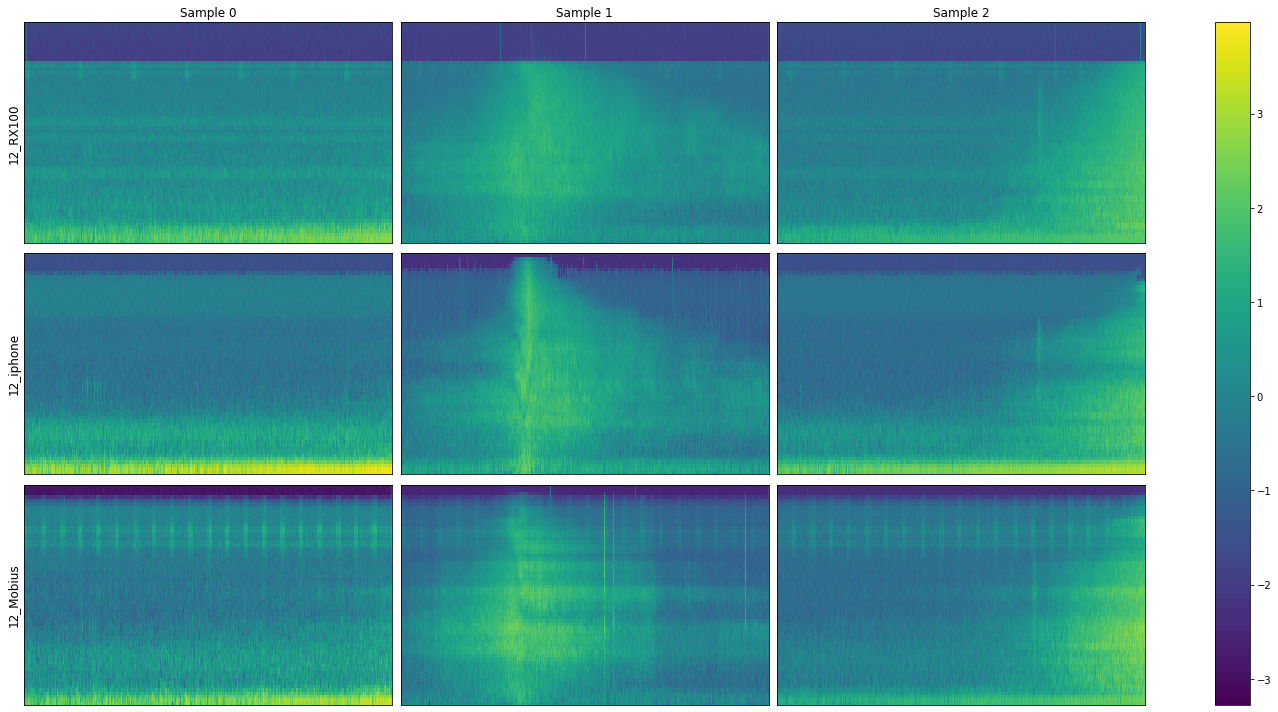

In [ ]:
n_domains = 3
n_samples = 3

s1, sr1 = torch.load('data/audio_tensors/12_RX100.MP4.pt')
s2, sr2 = torch.load('data/audio_tensors/12_iphone.MP4.pt')
s3, sr3 = torch.load('data/audio_tensors/12_Mobius.MP4.pt')

vmin = np.inf
vmax = -np.inf

features = defaultdict(list)

for i in range(n_samples):
    f_i = int(np.random.choice(len(s1)))
    f_j = int(f_i + 20 * sr1)
    
    for s in [s1, s2, s3]:
        X = s[f_i: f_j]
        X = transformation(X).squeeze()
        vmin = min(X.min(), vmin)
        vmax = max(X.max(), vmax)
        features[i].append(X)

fig, axes = plt.subplots(n_samples, n_domains, figsize=(20, 10))

for i in range(n_samples):
    for j in range(n_domains):
        ax = axes[i, j]
        im = ax.pcolormesh(features[j][i], vmin=vmin, vmax=vmax)
        
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

cols = [f'Sample {i}' for i in range(n_samples)]
rows = ['12_RX100', '12_iphone', '12_Mobius']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, size='large')
    
plt.tight_layout()
fig.colorbar(im, ax=axes.tolist());